# NN

## モジュールのインポート 

In [5]:
# load_data.ipynb にある関数 load_data() をモジュールとしてインポートするための記述
import sys
import notebookutil as nbu
sys.meta_path.append(nbu.NotebookFinder())
from load_data import load_data

import time
from tqdm import tqdm
import numpy as np
import itertools
import cv2
from PIL import Image
import matplotlib.pyplot as plt
# plt.style.use('dark_background') # jupyterの背景を黒くしている場合， 混同行列などの軸ラベルが見やすくなる．
% matplotlib inline

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import chainer 
from chainer import Variable, optimizers
import chainer.functions as F
import chainer.links as L
from chainer import initializers

## データセットの準備
- 駒の種類ごとに，train:test = 7:3 に分割
- 並び順はランダム

In [6]:
# データの読み込み
koma = load_data() # 駒の種類．混同行列に利用．
class_names = koma.target_names
x = koma.data 
y = koma.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# データ数、形状の確認
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

# サンプルの表示 
x_sample = x_train[0]

x_train: (38532, 80, 64, 3)
y_train: (38532,)
x_test: (16515, 80, 64, 3)
y_test: (16515,)


## 前処理

In [7]:
# Chainerでは実数のタイプはnp.float32, 整数のタイプはnp.int32に固定しておく必要がある．
x_train = x_train.astype(np.float32) # (40681, 80, 64, 3)
y_train = y_train.astype(np.int32) # (40681,)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.int32)

# 輝度を揃える
x_train /= x_train.max()
x_test /= x_test.max()

	元画像


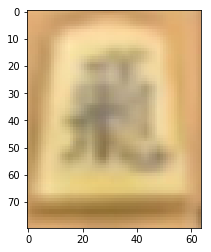


	グレースケール化後の画像


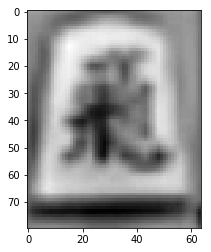


	閾値処理後の画像


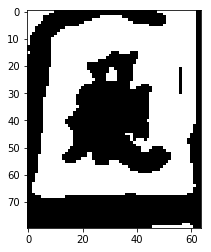

In [11]:
# グレースケール化→閾値処理のテスト
## 前処理前
sample_img = x_train[0]
print("\t元画像")
plt.imshow(sample_img)
plt.show()

## グレースケール化
gray_sample_img = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
print("\n\tグレースケール化後の画像")
plt.imshow(gray_sample_img, cmap="gray")
plt.show()

# # 閾値処理
_, threshold_sample_img = cv2.threshold(gray_sample_img, 0.7, 1, cv2.THRESH_BINARY)
print("\n\t閾値処理後の画像")
plt.imshow(threshold_sample_img, cmap="gray")
plt.show()

## 分類

In [29]:
koma = load_data()
x = koma.data
x = x.reshape(x.shape[0], 3, 80, 64) # (データ数，チャネル数(色数)，縦，横)の形式にする．
y = koma.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Chainerでは実数のタイプはfloat32, 整数のタイプはint32に固定しておく必要がある．
x_train = x_train.astype(np.float32) # (40681, 80, 64, 3)
y_train = y_train.astype(np.int32) # (40681,)
x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.int32)

## 輝度を揃える
x_train /= x_train.max()
x_test /= x_test.max()

In [30]:
# 訓練データに対する正答率，誤差を表示する関数
def train(model, optimizer, x_data, y_data, batchsize=10):
    N = x_data.shape[0] # データ数
    x_data, y_data = shuffle(x_data, y_data) # 学習する順番をランダムに入れ替え


    sum_accuracy = 0 # 累計正答率
    sum_loss = 0 # 累計誤差
    start = time.time() # 開始時刻

    # batchsize個ずつ学習
    for i in tqdm(range(0, N, batchsize)):
        x = chainer.Variable(np.asarray(x_data[i: i+batchsize]))
        t = chainer.Variable(np.asarray(y_data[i: i+batchsize]))

        # パラメータの更新(学習)
        optimizer.update(model, x, t)

        sum_loss += float(model.loss.data) * len(t.data) # 累計誤差を更新
        sum_accuracy += float(model.accuracy.data) * len(t.data) # 累計正答率を更新

    end = time.time() # 終了時刻
    elapsed_time = end - start # 所要時間
    throughput = N / elapsed_time # 単位時間当たりの作業量
    print("train mean loss={}, accuracy={}, throughput={} image/sec".format(sum_loss / N, sum_accuracy / N, throughput))

In [31]:
# テストデータに対する正答率，誤差を表示する関数
def test(model, x_data, y_data, batchsize=10):
    N = x_data.shape[0]
    x_data, y_data = shuffle(x_data, y_data)

    sum_accuracy = 0
    sum_loss = 0

    for i in tqdm(range(0, N, batchsize)):
        # 評価の時はvolatile *volatileをTrueにするとBackpropergationできない
        x = chainer.Variable(np.asarray(x_data[i: i+batchsize]))
        t = chainer.Variable(np.asarray(y_data[i: i+batchsize]))

        # 評価
        loss = model(x, t)
        sum_loss += float(loss.data) * len(t.data)
        sum_accuracy += float(model.accuracy.data) * len(t.data)

    print("test mean loss={}, accuracy={}".format(sum_loss / N, sum_accuracy / N))

### MLP

In [32]:
class MLP(chainer.Chain):
    def __init__(self, n_units):
        super(MLP, self).__init__(
            l1 = L.Linear(None, n_units), 
            l2 = L.Linear(n_units, n_units), 
            # l3 = L.Linear(n_units, n_units), 
        )
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        # h2 = F.relu(self.l2(h1))
        return self.l2(h1)

In [33]:
mlp = L.Classifier(MLP(1000)) # モデルの生成
optimizer = optimizers.Adam() # 最適化アルゴリズムの選択
optimizer.setup(mlp) # アルゴリズムにモデルをフィット

In [34]:
# train MLP
n_epoch = 10 # 学習回数(学習データを何周するか)
for epoch in range(1, n_epoch + 1):
    print("\nepoch", epoch)
    
    # 訓練
    train(mlp, optimizer, x_train, y_train, batchsize=100)
    
    # 評価
    test(mlp, x_test, y_test, batchsize=100)


epoch 1



  3%|▎         | 13/386 [00:12<05:03,  1.23it/s]

KeyboardInterrupt: 

## CNN

In [35]:
class CNN(chainer.Chain):

    def __init__(self):
        super(CNN, self).__init__(
            conv1=L.Convolution2D(3, 32, 3, stride=1, pad=2), # (入力チャンネル数、出力チャンネル数、フィルタサイズ)
            conv2=L.Convolution2D(32, 32, 3, stride=1, pad=2),
            conv3=L.Convolution2D(32, 64, 3, stride=1, pad=2),
            fc4=L.Linear(None, 64*10*8),
            fc5=L.Linear(None, 8),
        )

    def __call__(self, x):
        x = x.reshape(x.shape[0], 3, 80, 64) # (データ数、チャネル数(色数)、縦、横)の形式にする。
        h = F.relu(self.conv1(x)) # (32, 80, 64)
        h = F.max_pooling_2d(h, 2) # (32, 40, 32)
        h = F.relu(self.conv2(h))  # (32, 40, 32)
        h = F.max_pooling_2d(h, 2) # (32, 20, 16)
        h = F.relu(self.conv3(h)) # (64, 20, 16)
        h = F.dropout(F.relu(self.fc4(h)), ratio=0.5) # (64, 10, 8)
        return self.fc5(h)

In [36]:
# train CNN 0:42~
cnn = L.Classifier(CNN())
optimizer = optimizers.Adam()
optimizer.setup(cnn)

# train CNN
n_epoch = 10 # 学習回数(学習データを何周するか)
for epoch in range(1, n_epoch + 1):
    print("\nepoch", epoch)
    
    # 訓練
    train(cnn, optimizer, x_train, y_train, batchsize=100)
    
    # 評価
    test(cnn, x_test, y_test, batchsize=100)


epoch 1



  0%|          | 1/386 [00:42<4:30:53, 42.22s/it]

KeyboardInterrupt: 

##  ResNet

In [37]:
class ResBlock(chainer.Chain):

    def __init__(self, in_size, ch):
        super(ResBlock, self).__init__(
            conv1 = L.Convolution2D(in_size, ch, 1, 1, 0, initialW=initializers.HeNormal(), nobias=True),
            bn1 = L.BatchNormalization(ch),
            conv2 = L.Convolution2D(ch, ch, 3, 1, 1, initialW=initializers.HeNormal(), nobias=True),
            bn2 = L.BatchNormalization(ch),
            conv3 = L.Convolution2D(ch, in_size, 1, 1, 0, initialW=initializers.HeNormal(), nobias=True),
            bn3 = L.BatchNormalization(in_size),
        )

    def __call__(self, x):
        h = F.relu(self.bn1(self.conv1(x)))
        h = F.relu(self.bn2(self.conv2(h)))
        h = self.bn3(self.conv3(h))

        return F.relu(h + x)

class ResNetSmall(chainer.Chain):

    def __init__(self):
        super(ResNetSmall, self).__init__(
            conv1 = L.Convolution2D(3, 32, 5, initialW=initializers.HeNormal()),
            bn1 = L.BatchNormalization(32),
            res1= ResBlock(32, 32),
            res2= ResBlock(32, 32),
            res3= ResBlock(32, 32),
            fc=L.Linear(None, 10),
        )

    def __call__(self, x):
        h = self.bn1(self.conv1(x))
        h = F.max_pooling_2d(F.relu(h), 3, stride=2)
        h = self.res2(h)
        h = self.res3(h)
        h = F.average_pooling_2d(h, 7, stride=1)
        return self.fc(h)


In [38]:
resnet = L.Classifier(ResNetSmall()) # モデルの生成
optimizer = optimizers.Adam() # 最適化アルゴリズムの選択
optimizer.setup(resnet) # アルゴリズムにモデルをフィット

# train ResNet
n_epoch = 10 # 学習回数(学習データを何周するか)
for epoch in range(1, n_epoch + 1):
    print("\nepoch", epoch)
    
    # 訓練
    train(resnet, optimizer, x_train, y_train, batchsize=100)
    
    # 評価
    test(resnet, x_test, y_test, batchsize=100)


epoch 1



  0%|          | 0/386 [00:00<?, ?it/s]


KeyboardInterrupt: 